<a href="https://colab.research.google.com/github/YolandaMDavis/cs109a-fall2020/blob/covid-research/Boston_Covid_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
DATA_ROOT = '/content/drive/My Drive/CS109A/Final Project/covid_data/'

In [81]:
boston_covid_neighborhood_df = pd.read_csv(DATA_ROOT + 'boston_neighborhood_covid.csv')
boston_covid_neighborhood_df["total positive"] = boston_covid_neighborhood_df["total tested"] * boston_covid_neighborhood_df["cumulative positive"]
boston_covid_neighborhood_df = boston_covid_neighborhood_df.rename(columns={"neigborhood":"neighborhood"})
boston_covid_neighborhood_df.head()


,neighborhood,total tested,cumulative positive,total positive
0,East Boston,19590,0.13600,2664.2400
1,Mattapan,8652,0.11200,969.0240
2,Hyde Park,12726,0.11100,1412.5860
3,Dorchester,48850,0.10751,5251.8635
4,Roslindale,12005,0.08200,984.4100


In [82]:
boston_districts_df = pd.read_excel(DATA_ROOT + 'Boston-Neighborhoods-to-Districts.xlsx')
boston_districts_df

,Unnamed: 0,neighborhood,district
0,0,Allston,D14
1,1,Back Bay,D4
2,2,Beacon Hill,A1
3,3,Brighton,D14
4,4,Charlestown,A15
5,5,Dorchester,C11
6,6,Downtown,A1
7,7,East Boston,A7
8,8,Fenway,D4
9,9,Harbor Islands,NaN


In [83]:
boston_covid_districts = pd.merge(boston_covid_neighborhood_df,boston_districts_df, on="neighborhood").drop(columns=["Unnamed: 0"])
boston_covid_districts

,neighborhood,total tested,cumulative positive,total positive,district
0,East Boston,19590,0.136,2664.240,A7
1,Roslindale,12005,0.082,984.410,E5
2,Roxbury,23736,0.062,1471.632,B2
3,West Roxbury,9356,0.061,570.716,E5
4,South End,20060,0.057,1143.420,D4
5,Jamaica Plain,19720,0.049,966.280,E13
6,South Boston,16450,0.047,773.150,C6
7,Allston,12753,0.042,535.626,D14
8,Brighton,18697,0.042,785.274,D14
9,Charlestown,7060,0.039,275.340,A15


In [84]:
boston_covid_districts = boston_covid_districts.groupby("district").sum()[["total positive","total tested","cumulative positive"]]

In [85]:
boston_crime_df = pd.read_csv(DATA_ROOT + 'boston_crime.csv')
boston_crime_df.head()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
1,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"
2,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,NaN,2019-10-12 15:12:43,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)"
3,I192082577,724,Auto Theft,AUTO THEFT,D4,130,NaN,2019-10-12 04:41:52,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)"
4,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,NaN,2019-10-02 08:08:49,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)"


In [86]:
boston_crime_types_df = boston_crime_df[["DISTRICT","OFFENSE_CODE","OFFENSE_CODE_GROUP","OCCURRED_ON_DATE"]]
boston_crime_types_df.head()

,DISTRICT,OFFENSE_CODE,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE
0,E18,724,Auto Theft,2019-10-13 09:28:24
1,E18,724,Auto Theft,2019-10-12 20:11:26
2,D14,727,Auto Theft,2019-10-12 15:12:43
3,D4,724,Auto Theft,2019-10-12 04:41:52
4,A15,727,Auto Theft,2019-10-02 08:08:49


In [87]:
boston_crime_covid = pd.merge(boston_crime_types_df,boston_covid_districts, left_on="DISTRICT", right_on="district")
boston_crime_covid.head()

,DISTRICT,OFFENSE_CODE,OFFENSE_CODE_GROUP,OCCURRED_ON_DATE,total positive,total tested,cumulative positive
0,D14,727,Auto Theft,2019-10-12 15:12:43,1320.9,31450,0.084
1,D14,3114,Investigate Property,2019-09-29 02:39:00,1320.9,31450,0.084
2,D14,1402,Vandalism,2019-09-29 01:30:00,1320.9,31450,0.084
3,D14,3114,Investigate Property,2019-09-29 01:20:00,1320.9,31450,0.084
4,D14,3810,Motor Vehicle Accident Response,2019-09-28 21:49:00,1320.9,31450,0.084


In [88]:
print(boston_crime_covid["OFFENSE_CODE_GROUP"].sort_values().unique())

boston_crime_covid_by_offense = boston_crime_covid.groupby(["DISTRICT","total positive","total tested","OFFENSE_CODE_GROUP",]).count()["OFFENSE_CODE"].reset_index().rename(columns={"OFFENSE_CODE":"OFFENSE_COUNTS"})
boston_crime_covid_by_offense.head()


['Aggravated Assault' 'Aircraft' 'Arson'
 'Assembly or Gathering Violations' 'Auto Theft' 'Auto Theft Recovery'
 'Ballistics' 'Biological Threat' 'Bomb Hoax' 'Commercial Burglary'
 'Confidence Games' 'Counterfeiting' 'Criminal Harassment'
 'Disorderly Conduct' 'Drug Violation' 'Embezzlement' 'Evading Fare'
 'Explosives' 'Fire Related Reports' 'Firearm Discovery'
 'Firearm Violations' 'Fraud' 'Gambling' 'HOME INVASION'
 'HUMAN TRAFFICKING' 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'
 'Harassment' 'Harbor Related Incidents' 'Homicide' 'INVESTIGATE PERSON'
 'Investigate Person' 'Investigate Property' 'Landlord/Tenant Disputes'
 'Larceny' 'Larceny From Motor Vehicle' 'License Plate Related Incidents'
 'License Violation' 'Liquor Violation' 'Manslaughter'
 'Medical Assistance' 'Missing Person Located' 'Missing Person Reported'
 'Motor Vehicle Accident Response' 'Offenses Against Child / Family'
 'Operating Under the Influence' 'Other' 'Other Burglary'
 'Phone Call Complaints' 'Police Servic

,DISTRICT,total positive,total tested,OFFENSE_CODE_GROUP,OFFENSE_COUNTS
0,A1,476.523,17649,Aggravated Assault,1287
1,A1,476.523,17649,Arson,8
2,A1,476.523,17649,Assembly or Gathering Violations,282
3,A1,476.523,17649,Auto Theft,459
4,A1,476.523,17649,Auto Theft Recovery,82


In [89]:
district_crime_covid = boston_crime_covid.groupby(["DISTRICT","total positive","total tested"]).count()["OFFENSE_CODE"].reset_index().rename(columns={"OFFENSE_CODE":"offenses"})
district_crime_covid.head()

,DISTRICT,total positive,total tested,offenses
0,A1,476.523,17649,47718
1,A15,275.340,7060,8644
2,A7,2664.240,19590,17175
3,B2,1471.632,23736,67967
4,C6,773.150,16450,31043


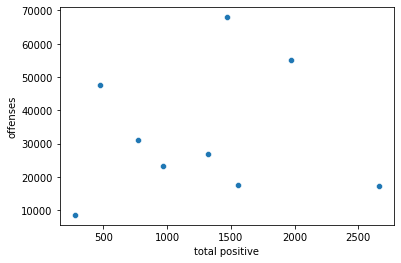

In [90]:
sns.scatterplot(data=district_crime_covid, x="total positive", y="offenses")

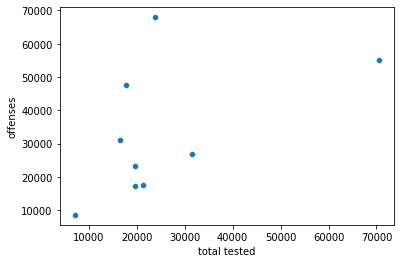

In [91]:
sns.scatterplot(data=district_crime_covid, x="total tested", y="offenses")

Text(0.5, 0, 'Total Positive Cases')

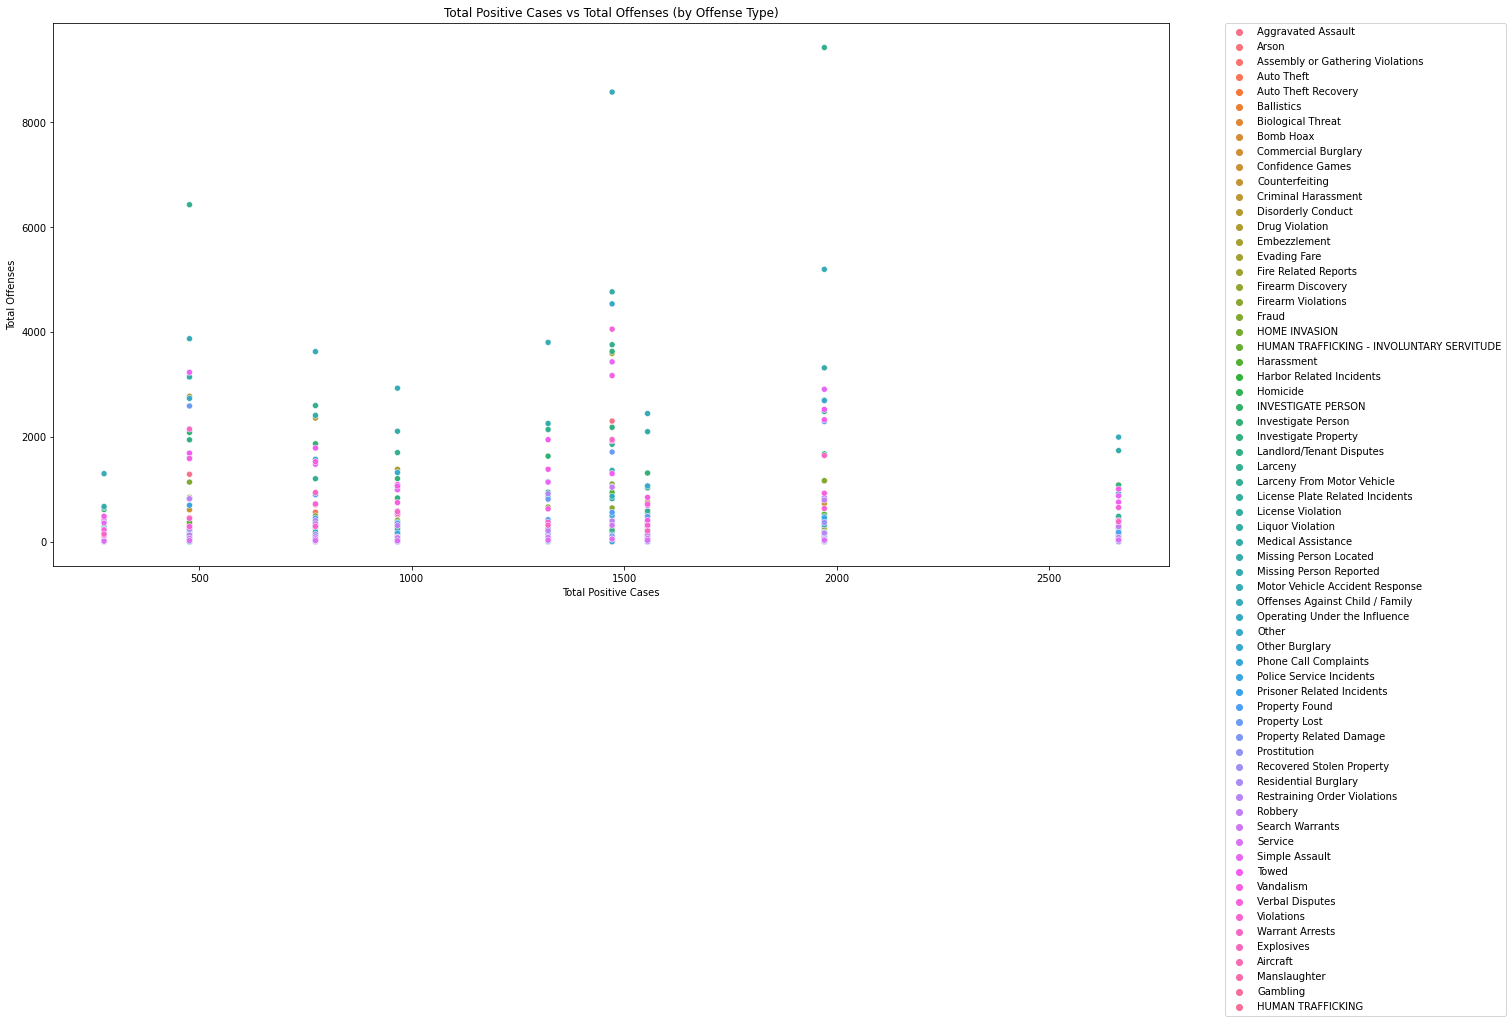

In [92]:
district_crime_covid_by_offense = boston_crime_covid.groupby(["DISTRICT","total positive","total tested","OFFENSE_CODE_GROUP"]).count()["OFFENSE_CODE"].reset_index().rename(columns={"OFFENSE_CODE":"offenses","OFFENSE_CODE_GROUP":"offense_type"})

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=district_crime_covid_by_offense, x="total positive", y="offenses", hue="offense_type", ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(f"Total Positive Cases vs Total Offenses (by Offense Type)")    
ax.set_ylabel("Total Offenses")
ax.set_xlabel("Total Positive Cases")

Text(0.5, 0, 'Total Test Cases')

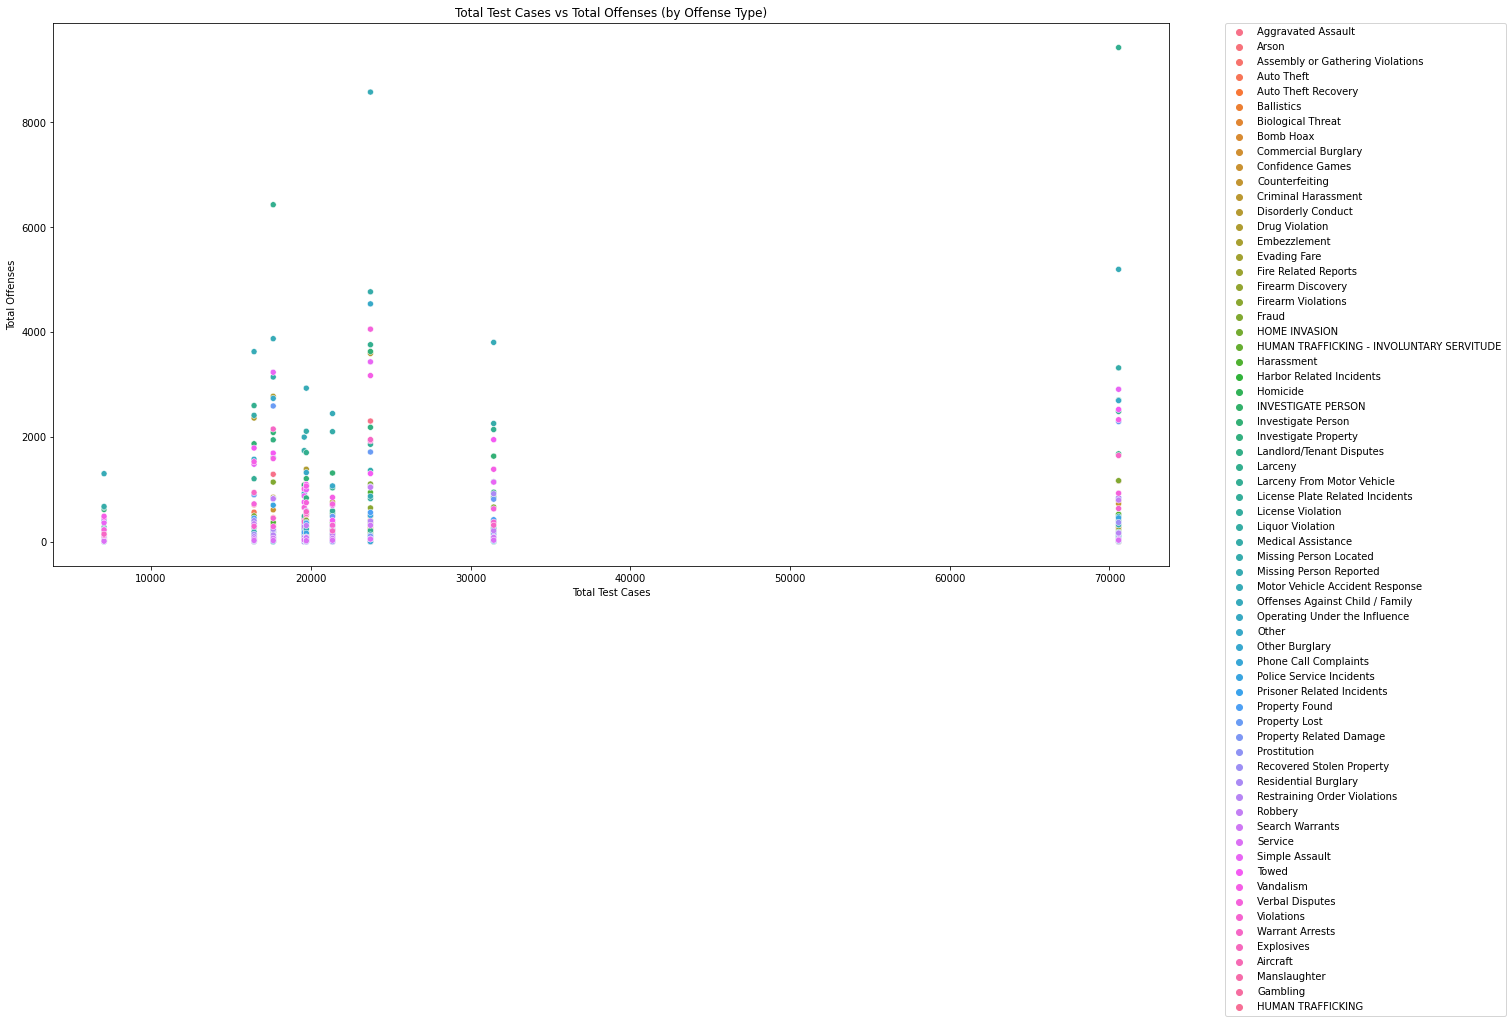

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=district_crime_covid_by_offense, x="total tested", y="offenses", hue="offense_type", ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title(f"Total Test Cases vs Total Offenses (by Offense Type)")    
ax.set_ylabel("Total Offenses")
ax.set_xlabel("Total Test Cases")

In [94]:
unique_offenses = boston_crime_covid.groupby(["OFFENSE_CODE_GROUP"]).count()["OFFENSE_CODE"].sort_values(ascending=False)
unique_offenses

OFFENSE_CODE_GROUP
Motor Vehicle Accident Response              33751
Larceny                                      28630
Medical Assistance                           22514
Other                                        16406
Investigate Person                           16132
                                             ...  
HUMAN TRAFFICKING                                6
Gambling                                         5
INVESTIGATE PERSON                               4
Biological Threat                                3
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE        2
Name: OFFENSE_CODE, Length: 66, dtype: int64

In [95]:
offense_groups = unique_offenses.index

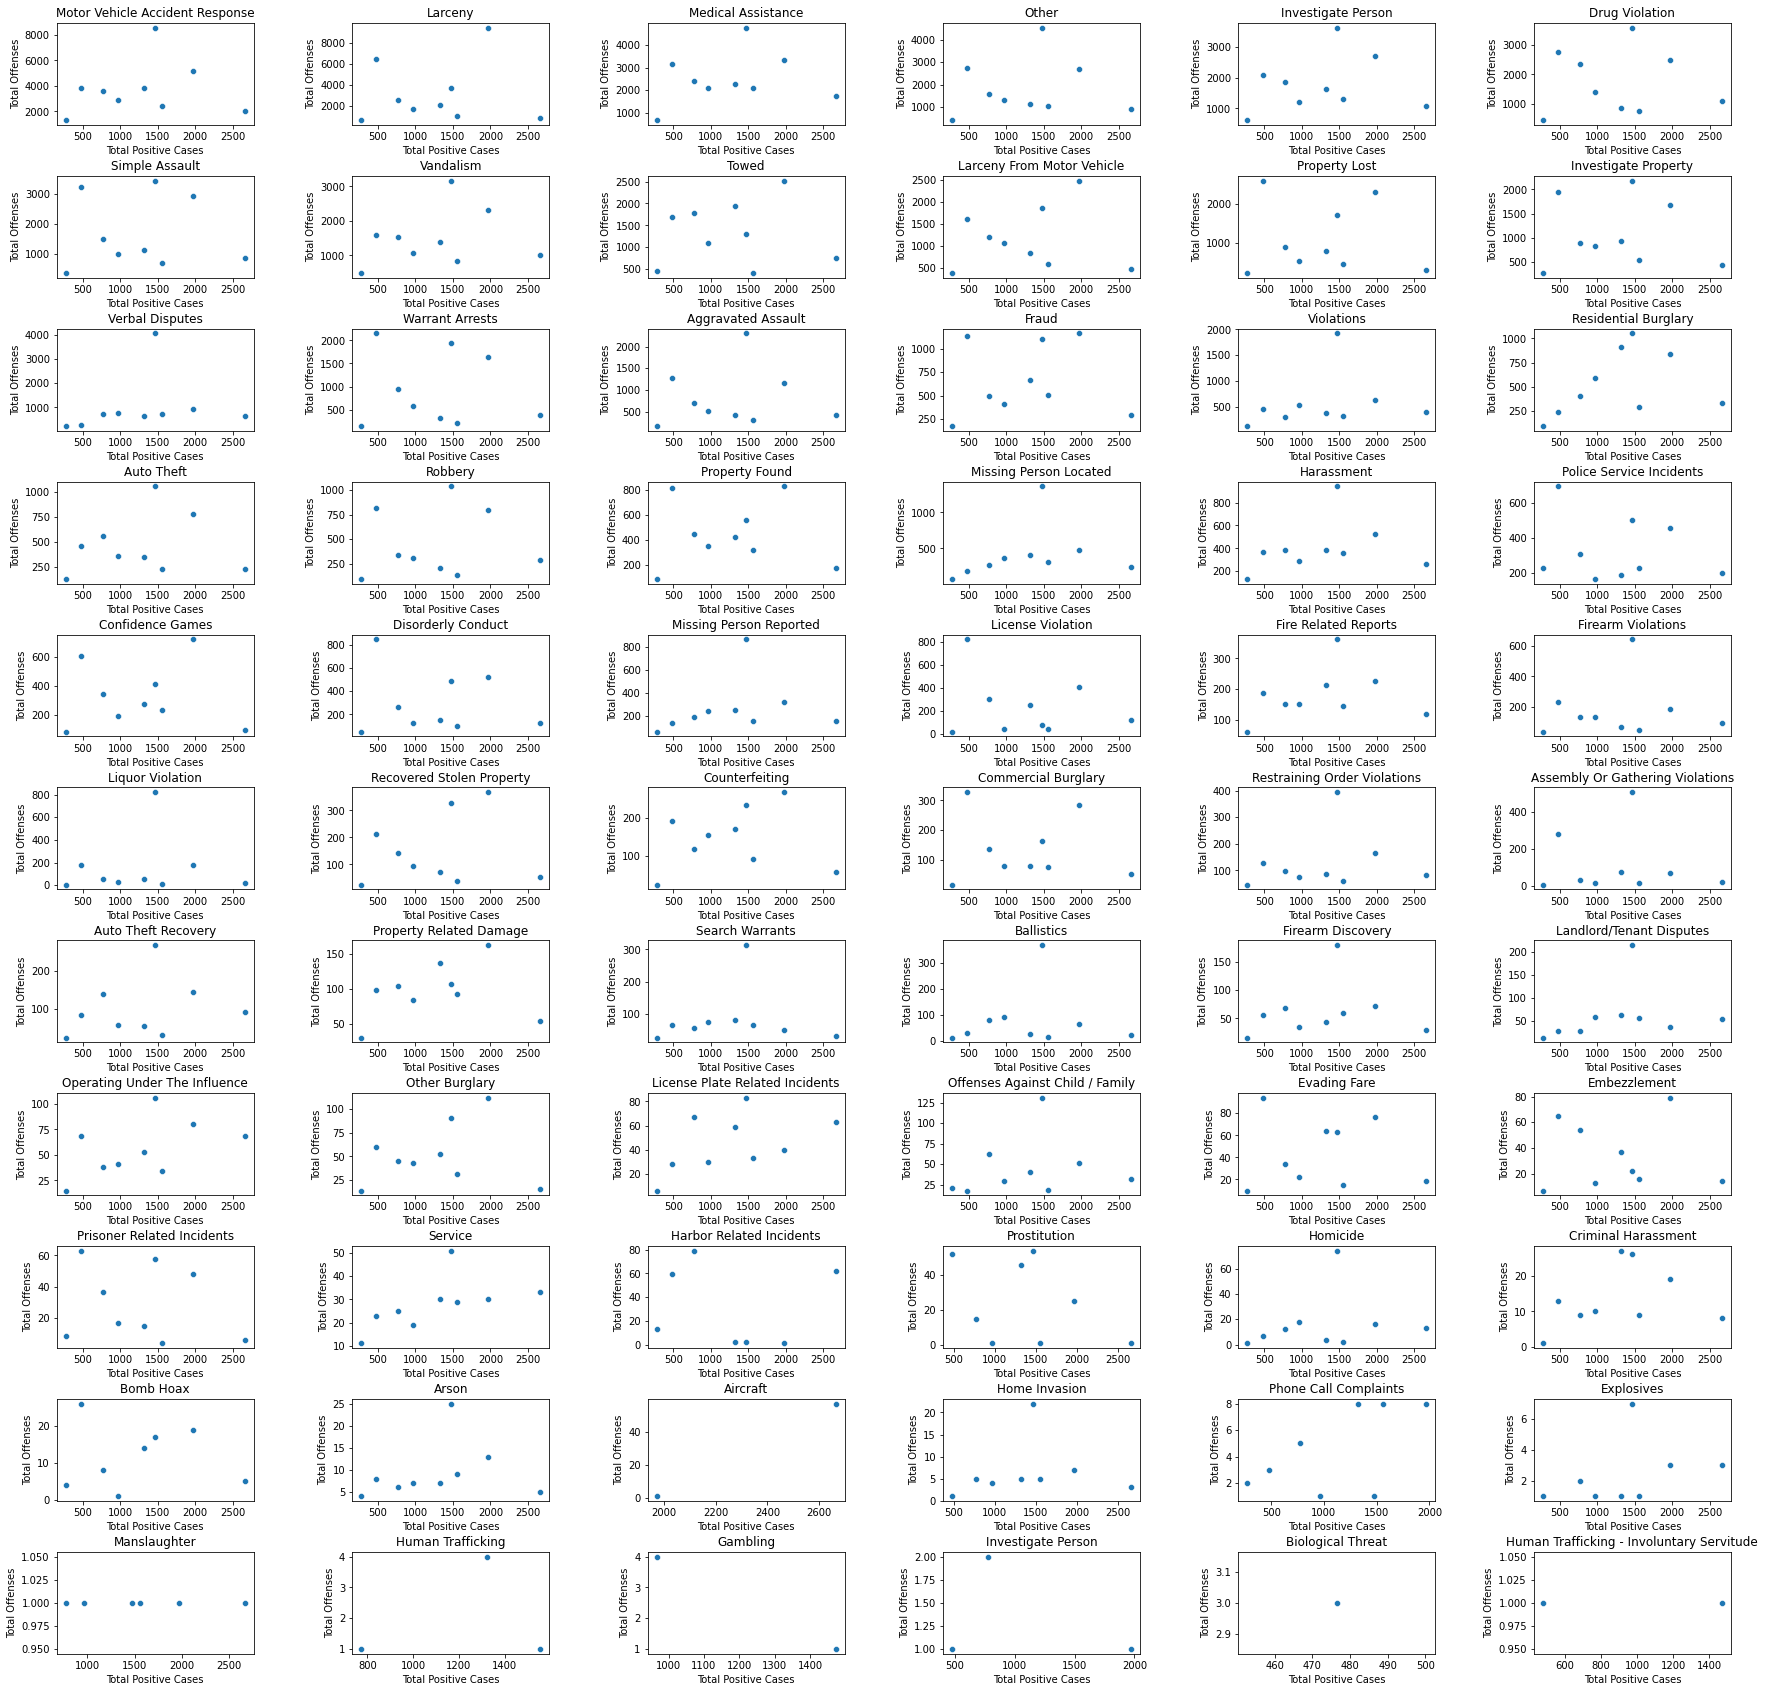

In [96]:
fig, ax = plt.subplots(11,6, figsize=(30,30))
row_idx = 0

for i, offense in enumerate(offense_groups):

  if(i > 0) and (i % 6 == 0):
        row_idx+=1
    
  col= i % 6    
  row = row_idx
  pred_ax = ax[row, col]

  crime_covid_offense = district_crime_covid_by_offense[district_crime_covid_by_offense["offense_type"] == offense]
  sns.scatterplot(data=crime_covid_offense, x="total positive", y="offenses", ax=pred_ax)
  pred_ax.set_title(f"{offense.replace('_',' ').title()}")    
  pred_ax.set_ylabel("Total Offenses")
  pred_ax.set_xlabel("Total Positive Cases")

plt.subplots_adjust(hspace=0.5,wspace=.5)